# Classificador de spam

Esse projeto tem como objetivo classificar emails como legítimos (**ham**) ou falsos (**spam**). Temos então um problema de classificação binário supervisionado offline. Em particular, estamos trabalhando com um problema de linguagem natural (**NLP**).

O dataset que iremos utilizar foi obtido na etapa de ETL, e contém as seguintes colunas:

| Coluna | Descrição |
---------|------------
id | identificador único do email
email_content | conteúdo do email (mensagem)
email_structure | estrutura do email (texto, html, etc)
email_type | Target (spam ou ham)

Devido a natureza do problema, estamos particularmente interessado na métrica de **precisão**, mas outras métricas serão computadas para auxiliar a diagnose dos modelos obtidos.

## Importando bibliotecas e dados

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder 

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

import re
import string
from unidecode import unidecode

In [2]:
df = pd.read_csv('../data/treated_data/data.csv')
df.head()

,id,email_content,email_structure,email_type
0,00001.7848dde101aa985090474a91ec93fcf0,\n\n\n\n\n\n\n\n\n\n\n\n\n\nSave up to 70% on ...,text/html,spam
1,00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\nURL\n\n2) Slim D...,text/plain,spam
2,00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\nURL\n\n2) Slim D...,text/plain,spam
3,00004.eac8de8d759b7e74154f142194282724,##############################################...,text/plain,spam
4,00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n1) Slim Down ...,text/plain,spam


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               3000 non-null   object
 1   email_content    2999 non-null   object
 2   email_structure  3000 non-null   object
 3   email_type       3000 non-null   object
dtypes: object(4)
memory usage: 93.9+ KB


## Pré-processamento

In [4]:
# Checando e dropando NaN 

print(df.isna().sum())
df_tr1 = df.dropna()

id                 0
email_content      1
email_structure    0
email_type         0
dtype: int64


In [5]:
# Checando emails duplicados e removendo emails duplicados

print(f"Duplicated emails: {df_tr1['email_content'].duplicated().sum()}")
df_tr2 = df_tr1[~df_tr1['email_content'].duplicated()]

Duplicated emails: 90


In [6]:
def preprocessing(df):
    """Executa uma série de procedimentos de limpeza de texto."""
    
    email_content = df['email_content'] # Separa a coluna com os emails
    email_content = email_content.apply(lambda x: x.lower()) # Minúsculas
    email_content = email_content.apply(lambda x: re.sub(r'\d+', '', x)) # Remove números
    email_content = email_content.apply(lambda x: re.sub("[.]", " ", x)) # Remove pontos
    email_content = email_content.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x)) # Remove pontuação
    email_content = email_content.str.replace('\n', ' ') # Remove \n
    email_content = email_content.apply(lambda x: re.sub(r'\s{2,}', ' ', x)) # Remove espaços repetidos
    email_content = email_content.str.strip() # Remove trailing spaces
    email_content = email_content.apply(lambda x: unidecode(x, errors="preserve")) # Remove erros de decode
    
    df.loc[:,'email_content'] = email_content
    return df

In [7]:
df_tr3 = preprocessing(df_tr2)

<ipython-input-6-62fc0dae1493>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'email_content'] = email_content


In [8]:
df_tr3.sample(10, random_state=42)

,id,email_content,email_structure,email_type
921,00422.ac4b66f9c3390c3a98d9c8cbe75f403a,hindus got billion gods so losing one is no bi...,text/plain,ham
1276,00777.5abc0824f35b966cf589b15c4f10f2d2,anyone heard of this law before q can i get a ...,text/plain,ham
928,00429.5c83e9a65ee27155654607ee770b8142,someone needs to tell the mayor about this url...,text/plain,ham
400,00401.309e29417819ce39d8599047d50933cc,a great sponsor will not make you money a grea...,text/plain,spam
651,00152.703c271de3d42fb8bf266db6f77a0dda,thanks for the info aj i found weblog at url w...,text/plain,ham
2643,02144.9288d3523cb8cb036f166e3b69c7ce05,url url date t url,text/plain,ham
348,00349.dd7982f40576ff4897c18efc813e38bf,dear free member you were gifted a free member...,text/plain,spam
2211,01712.c20d5899b4b27415389a10cd4f400019,guido on the classifier pickle on sf i downloa...,text/plain,ham
2395,01896.516f258e3f8185d4a0e002a7d806bddf,url url date not supplied stefan sez a federal...,text/plain,ham
531,00032.57e29a75bca42afb412fc68d5051aa20,an apparent quote from dubya from the times se...,text/plain,ham


## Train test split

In [9]:
# Train test split

X = df_tr2['email_content']
y = df_tr2['email_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
# Label encoding

label_encoder = LabelEncoder()

y_train_tr = label_encoder.fit_transform(y_train)
y_test_tr = label_encoder.transform(y_test)

## EDA

### Balanceamento do target

In [11]:
# Verificando proporções dos targets

y_train.value_counts(normalize=True)

ham     0.846154
spam    0.153846
Name: email_type, dtype: float64

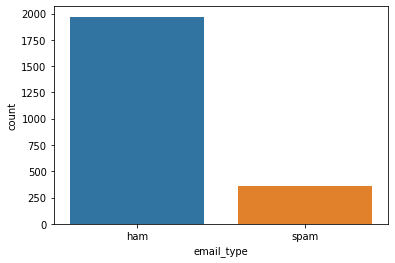

In [12]:
ax = sns.countplot(x=y_train)

As classes estão desbalanceadas. Podemos usar `class_weight=balanced` ou futuramente fazer undersampling caso seja necessário.

### Análise de sentimentos

In [13]:
# Sentiment analysis

sentiment_analyzer = SentimentIntensityAnalyzer()

df_tr4 = df_tr3.copy()
df_tr4['negative_sentiment'] = df_tr4['email_content'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['neg'])
df_tr4['neutral_sentiment'] = df_tr4['email_content'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['neu'])
df_tr4['positive_sentiment'] = df_tr4['email_content'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['pos'])

In [14]:
df_tr4.head()

,id,email_content,email_structure,email_type,negative_sentiment,neutral_sentiment,positive_sentiment
0,00001.7848dde101aa985090474a91ec93fcf0,save up to on life insurance why spend more th...,text/html,spam,0.035,0.700,0.265
1,00002.d94f1b97e48ed3b553b3508d116e6a09,fight the risk of cancer url slim down guarant...,text/plain,spam,0.140,0.644,0.216
2,00003.2ee33bc6eacdb11f38d052c44819ba6c,fight the risk of cancer url slim down guarant...,text/plain,spam,0.164,0.582,0.254
3,00004.eac8de8d759b7e74154f142194282724,adult club offers free membership instant acce...,text/plain,spam,0.039,0.768,0.193
4,00005.57696a39d7d84318ce497886896bf90d,i thought you might like these slim down guara...,text/plain,spam,0.165,0.646,0.190


In [15]:
# Email mais negativo
df_tr4.loc[df_tr4['negative_sentiment'].idxmax()]

id                    00042.3e934ba4075f82283d755174d2642b76
email_content            freak cock click here to be removed
email_structure                                    text/html
email_type                                              spam
negative_sentiment                                     0.474
neutral_sentiment                                      0.526
positive_sentiment                                       0.0
Name: 41, dtype: object

In [16]:
# Email mais positivo
df_tr4.loc[df_tr4['positive_sentiment'].idxmax()]

id                               02466.b71ae3ebfc7860ad17eabdf70410279a
email_content         url httpdiveintomark org date t upon arriving ...
email_structure                                              text/plain
email_type                                                          ham
negative_sentiment                                                  0.0
neutral_sentiment                                                 0.587
positive_sentiment                                                0.413
Name: 2965, dtype: object

In [17]:
# Email mais neutro
df_tr4.loc[df_tr4['neutral_sentiment'].idxmax()]

id                               00028.ace98eff213f4e6314b5571aece625e1
email_content         milfhunter milf hunter do you know where your ...
email_structure                                               text/html
email_type                                                         spam
negative_sentiment                                                  0.0
neutral_sentiment                                                   1.0
positive_sentiment                                                  0.0
Name: 27, dtype: object

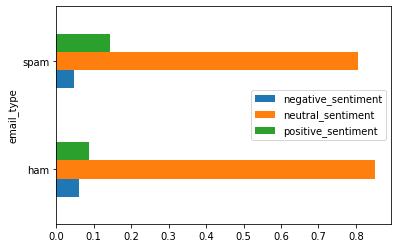

In [18]:
# Plotting mean sentiment distribution

mean_sentiment = df_tr4[['negative_sentiment', 
                         'neutral_sentiment', 
                         'positive_sentiment', 
                         'email_type']].groupby('email_type').mean()

mean_sentiment.plot(kind='barh')
plt.show()

In [19]:
mean_sentiment

,negative_sentiment,neutral_sentiment,positive_sentiment
email_type,,,
ham,0.061228,0.851845,0.086942
spam,0.047228,0.804583,0.143799


Emails `spam` são proporcionalmente menos negativos e neutros, e mais positivos que os emails `ham`. Poderiamos utilizar isso como feature.

### Tipo de email

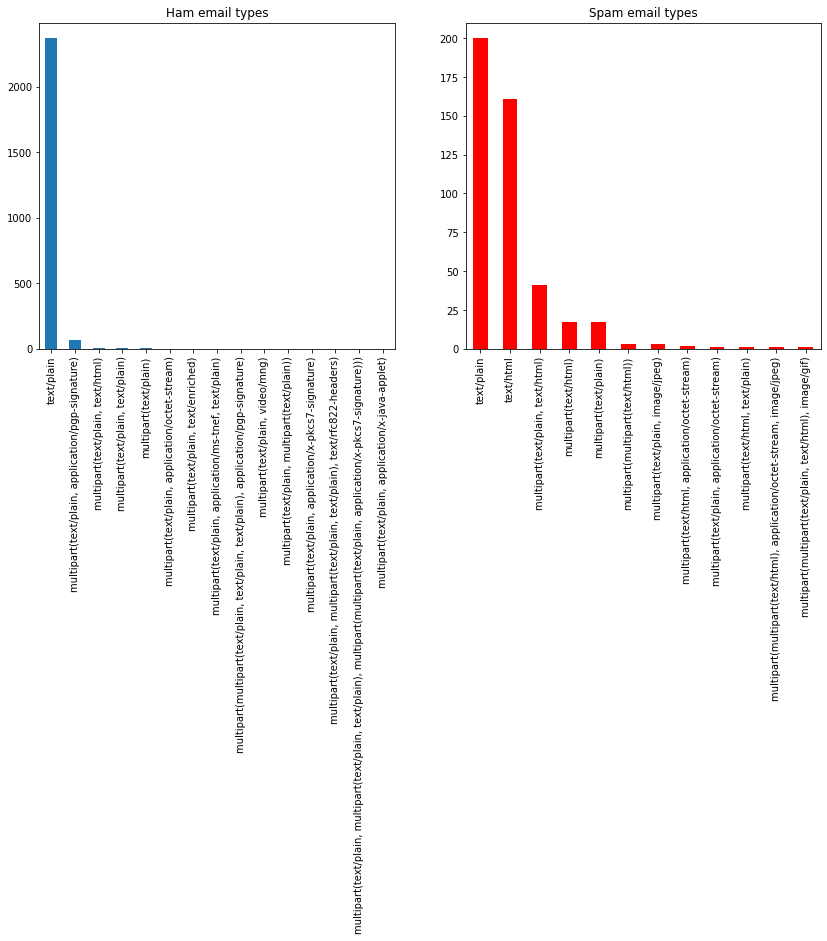

In [20]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
df_tr4.loc[df_tr4['email_type'] == 'ham', 'email_structure'].value_counts().plot(kind='bar')
plt.title('Ham email types')

plt.subplot(1,2,2)
df_tr4.loc[df_tr4['email_type'] == 'spam', 'email_structure'].value_counts().plot(kind='bar', color='r')
plt.title('Spam email types')

plt.show()

A análise dos tipos de email mostrou que os emails `ham` são majoritariamente do tipo `text/plain`, enquanto os `spam` se distribuem em múltiplas categorias multipart. Futuramente podemos utilizar isso como feature.

### Word cloud

In [21]:
spam_text = ''.join(df_tr3.loc[df_tr3['email_type'] =='spam','email_content'])
ham_text = ''.join(df_tr3.loc[df_tr3['email_type'] =='ham','email_content'])

In [22]:
from wordcloud import WordCloud

wc_ham = WordCloud(width=500, height=500, random_state=42)
wc_spam = WordCloud(width=500, height=500, random_state=42)

wc_ham.generate(ham_text)
wc_spam.generate(spam_text)

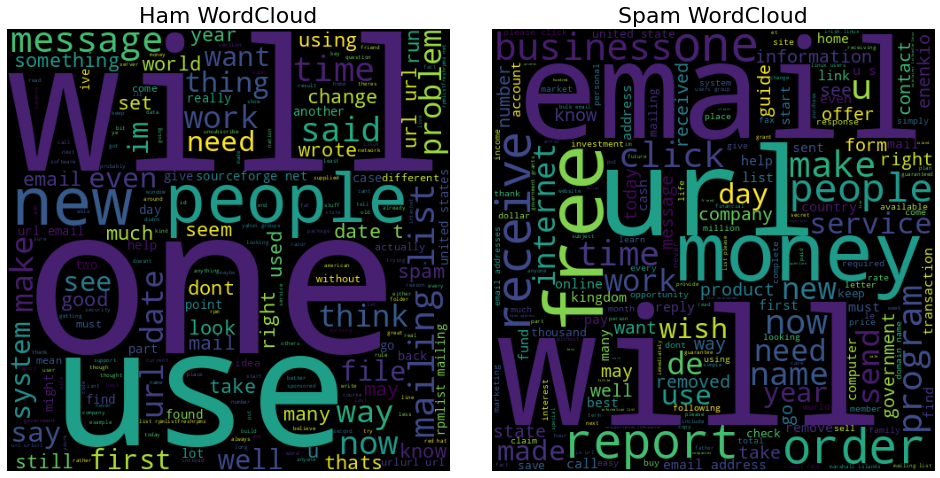

In [23]:
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.imshow(wc_ham)
plt.title('Ham WordCloud', fontsize=22)
plt.axis('off')
plt.tight_layout(pad=2)

plt.subplot(1,2,2)
plt.imshow(wc_spam)
plt.title('Spam WordCloud', fontsize=22)
plt.axis('off')
plt.tight_layout(pad=2)

plt.savefig('../img/header.png')

plt.show()

Como esperado, spams tem palavras chaves apelativas como: 'free', 'money, 'click', enquanto hams possuem palavras mais neutras como 'one', 'time', 'use'.

### Verificando a separabilidade dos dados

In [24]:
tsne = TSNE(n_components=2, init="random")

tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
pipeline = Pipeline([('vectorizer', tfidf), 
                     ('tsne', tsne)])


X_train_reduced = pipeline.fit_transform(X_train)

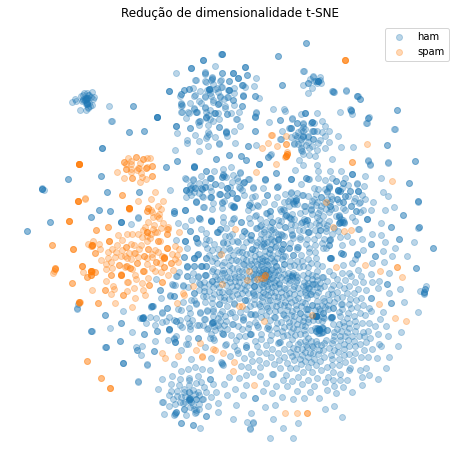

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(X_train_reduced[y_train_tr == 0,0], X_train_reduced[y_train_tr == 0,1], alpha=0.3, label='ham')
plt.scatter(X_train_reduced[y_train_tr == 1,0], X_train_reduced[y_train_tr == 1,1], alpha=0.3, label='spam')
plt.legend()
plt.title('Redução de dimensionalidade t-SNE')
plt.axis('off')
plt.show()

Reduzindo a dimensionalidade com o t-SNE vemos que os dados provavelmente possuem boa separabilidade.

## Treinando modelos

In [26]:
def report_metrics(scores):
    """ Calcula as métricas utilizando uma matriz score provinda do cross_validate."""
    print(f"Accuracy: {scores['test_accuracy'].mean():.3f} ({scores['test_accuracy'].std():.3f})")
    print(f"Precision: {scores['test_precision_macro'].mean():.3f} ({scores['test_precision_macro'].std():.3f})")
    print(f"Recall: {scores['test_recall_macro'].mean():.3f} ({scores['test_recall_macro'].std():.3f})")
    print(f"Fit time: {scores['fit_time'].mean():.3f} ({scores['fit_time'].std():.3f})")

### Random Forest

In [27]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
forest_clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

pipeline = Pipeline([('vectorizer', tfidf), 
                     ('model', forest_clf)])

metrics = ['accuracy', 'precision_macro', 'recall_macro']
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

forest_scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=stratified_kfold)

### Logistic Regression

In [28]:
log_clf = LogisticRegression(class_weight='balanced')

pipeline = Pipeline([('vectorizer', tfidf), 
                     ('model', log_clf)])

log_scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=stratified_kfold)
report_metrics(log_scores)

Accuracy: 0.985 (0.007)
Precision: 0.983 (0.010)
Recall: 0.957 (0.016)
Fit time: 0.771 (0.117)


### KNN 

In [29]:
knn_clf = KNeighborsClassifier(n_neighbors=15)

pipeline = Pipeline([('vectorizer', tfidf), 
                     ('model', knn_clf)])

knn_scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=stratified_kfold)
report_metrics(knn_scores)

Accuracy: 0.969 (0.008)
Precision: 0.953 (0.020)
Recall: 0.928 (0.012)
Fit time: 0.445 (0.118)


### SVC

In [30]:
svc_clf = SVC(kernel='linear', class_weight='balanced')

pipeline = Pipeline([('vectorizer', tfidf), 
                     ('model', svc_clf)])

svc_scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=stratified_kfold)
report_metrics(svc_scores)

Accuracy: 0.986 (0.004)
Precision: 0.989 (0.005)
Recall: 0.956 (0.012)
Fit time: 1.590 (0.280)


### LGBM

In [31]:
lgbm_clf = LGBMClassifier(class_weight='balanced')

pipeline = Pipeline([('vectorizer', tfidf), 
                     ('model', lgbm_clf)])

lgbm_scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=stratified_kfold)
report_metrics(lgbm_scores)

Accuracy: 0.974 (0.004)
Precision: 0.944 (0.013)
Recall: 0.960 (0.011)
Fit time: 2.468 (1.824)


### Deep Learning

In [32]:
# Vetorizar

count_vectorizer = CountVectorizer()
X_train_vec = count_vectorizer.fit_transform(X_train)
X_train_vec.sort_indices()

In [33]:
# Criando a rede neural

def make_classifier():
    nn = Sequential()
    nn.add(Dense(units=10, activation='relu', input_dim=X_train_vec.shape[1])) # Input layer
    nn.add(Dropout(0.1)) # Remove aleatoriamente 1% das sinapses
    nn.add(Dense(units=8, activation='relu')) # Hidden layer
    nn.add(Dense(units=1, activation='sigmoid')) # Output layer
    nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return nn

model = KerasClassifier(build_fn=make_classifier, epochs=20, batch_size=10, verbose=0)

nn_scores = cross_validate(model, X_train_vec, y_train_tr, scoring=metrics, cv=stratified_kfold)
report_metrics(nn_scores)

<ipython-input-33-b2d3794afece>:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=make_classifier, epochs=20, batch_size=10, verbose=0)


15/15 [==============================] - 0s 2ms/step
Accuracy: 0.989 (0.007)
Precision: 0.981 (0.014)
Recall: 0.976 (0.013)
Fit time: 19.268 (1.043)


Dentre os modelos treinados, o `SVC` se mostrou o mais promissor, por ser um modelo de simples entendimento, rápido e com excelentes resultados. As redes neurais podem oferecer resultados melhores, ao custo de tempo de treinamento e otimização de hiperparâmetros.

# Avaliação final

In [34]:
# Melhor modelo

svc_clf = SVC(kernel='linear', class_weight='balanced', probability=True)

pipeline = Pipeline([('vectorizer', tfidf), 
                     ('model', svc_clf)])

pipeline.fit(X_train, y_train_tr)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('model',
                 SVC(class_weight='balanced', kernel='linear',
                     probability=True))])

In [35]:
# Avaliação de treino

y_train_pred = pipeline.predict(X_train)
print(classification_report(y_train_tr, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1969
           1       1.00      0.99      1.00       358

    accuracy                           1.00      2327
   macro avg       1.00      1.00      1.00      2327
weighted avg       1.00      1.00      1.00      2327



In [36]:
# Avaliação de teste

y_test_pred = pipeline.predict(X_test)
print(classification_report(y_test_tr, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       492
           1       1.00      0.91      0.95        90

    accuracy                           0.99       582
   macro avg       0.99      0.96      0.97       582
weighted avg       0.99      0.99      0.99       582



A performance é praticamente perfeita tanto em treino quanto em teste.

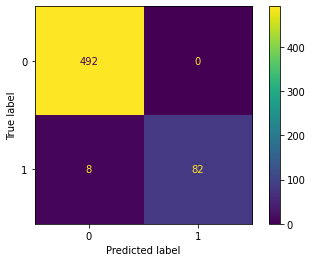

In [37]:
# Matriz de confusão

cm = confusion_matrix(y_test_tr, y_test_pred)

ConfusionMatrixDisplay(cm).plot()
plt.show()

Os únicos erros foram 8 falsos negativos.

In [38]:
# Emails classificados incorretamente

X_test[y_test_tr != y_test_pred]

318    foreword after thirtythree years of being a bl...
288    would you like to know what the powerball winn...
242    x mahc xuaaxudii zqtbhynxazda wnzbaxzziiii pug...
480    gbbynwsqurunbqufqrzktefxnosbihorxnpuqsbvphorht...
306    Mian Fei Wu Xian Ci Ren Da Zhong Gang Chang Tu...
359    hallo i found yours email id in directoric i h...
258    dear sirmadam i got this email id from your we...
125    this messsage was sent using the trial version...
Name: email_content, dtype: object

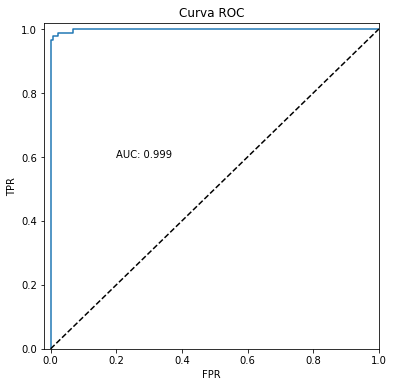

In [39]:
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_tr, y_test_proba)
auc = np.round(roc_auc_score(y_test, y_test_proba),3)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.02, 1.00])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.annotate(text=f'AUC: {auc}', xy=(0.2, 0.6))
plt.show()

O AUC é praticamente máximo, o que comprova a perfomance do modelo.

## Conclusão

O modelo se mostrou excepcional para classificar os dados estudados, com uma performance quase perfeita. Contudo poderiamos trabalhar com outros datasets mais complexos disponíveis. Nesse pode ser necessário um pré-processamento de dados mais elaborado, técnicas de balanceamento (em especial, undersampling), técnicas de NLP (lemmatizing, steeming, etc) e melhor otimização de modelos mais complexos, como os baseados em árvore ou as redes neurais. 